# Inhomogeneous Broadening Diagnostics

This notebook explores Gaussian inhomogeneous broadening used in `qspectro2d`. It provides:

- Visual checks that sampling routines reproduce the target distributions.
- Diagnostics confirming that sampled frequencies modify the system Hamiltonian.
- Integration tests showing how inhomogeneity propagates through full simulation objects.

All plots follow the project plotting style and highlight whether the statistical targets are met.

In [ ]:
from pathlib import Path
from qspectro2d.config import *  # provides CONFIG and mpl settings
from qutip import *

custom_dir = Path("test_N_atoms_geometry")
custom_dir.mkdir(exist_ok=True)

from plotstyle import COLORS, MARKERS, LINE_STYLES, save_fig, format_sci_notation, init_style
init_style()

## Environment Setup

Import simulation utilities, plotting helpers, and configure figure output directories for the tests below.

In [2]:
# Test and visualize Gaussian inhomogeneity sampling
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Sequence

from qspectro2d.spectroscopy.inhomogenity import normalized_gauss, sample_from_gaussian, _fwhm_to_sigma

def plot_gaussian_check(
    mu: float,
    fwhm: float,
    *,
    n_samples: int = 100_000,
    max_detuning: float = 10.0,
    bins: int = 200,
    ax: Optional[plt.Axes] = None,
    colors: Optional[Sequence[str]] = None,
    linestyles: Optional[Sequence[str]] = None,
) -> Tuple[float, float]:
    """Draw samples and overlay with the theoretical normalized Gaussian.

    Returns (sample_mean, sample_std).
    """
    if colors is None:
        colors = (COLORS[0], COLORS[1])
    if linestyles is None:
        linestyles = (LINE_STYLES[0],)
    if len(colors) < 2:
        raise ValueError("Provide at least two colors to avoid duplicates in one plot.")

    # Sample
    samples      = sample_from_gaussian(n_samples, fwhm, mu, max_detuning=max_detuning)
    samples      = np.asarray(samples, dtype=float).ravel()

    # Stats
    mu_hat       = float(np.mean(samples))
    std_hat      = float(np.std(samples, ddof=1))
    sigma_theory = _fwhm_to_sigma(fwhm)

    # X-grid for theory
    span         = 2.5 * fwhm
    x_min        = mu - span
    x_max        = mu + span
    x            = np.linspace(x_min, x_max, 1000)
    y            = normalized_gauss(x, fwhm=fwhm, mu=mu)

    # Plot
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4.5))
    ax.hist(
        samples,
        bins=bins,
        range=(x_min, x_max),
        density=True,
        color=colors[0],
        histtype="step",
        linewidth=1.5,
        label=rf"samples ($n={n_samples}$)"
    )
    ax.plot(
        x,
        y,
        color=colors[1],
        linestyle=linestyles[0],
        linewidth=2.0,
        label=rf"theory $\mathcal{{N}}(\mu={mu:.1f},\,\mathrm{{FWHM}}={fwhm:.1f})$"
    )

    # Labels
    ax.set_xlabel(r"Frequency $\nu$ (cm$^{-1}$)")
    ax.set_ylabel(r"Probability density")
    ax.set_title(
        rf"Gaussian samples vs. theory — $\mu={mu:.1f}$, FWHM={fwhm:.1f}, $\sigma_\mathrm{{th}}={sigma_theory:.2f}$; "
        rf"$\bar x={mu_hat:.2f}$, $s={std_hat:.2f}$"
    )
    ax.legend()
    ax.set_xlim(x_min, x_max)

    return mu_hat, std_hat

## Gaussian Sampling Utility

Define a helper that draws samples from the inhomogeneous Gaussian distribution and overlays histograms with the theoretical density. The plotting routine enforces unique colors and linestyles to match the thesis styling rules.

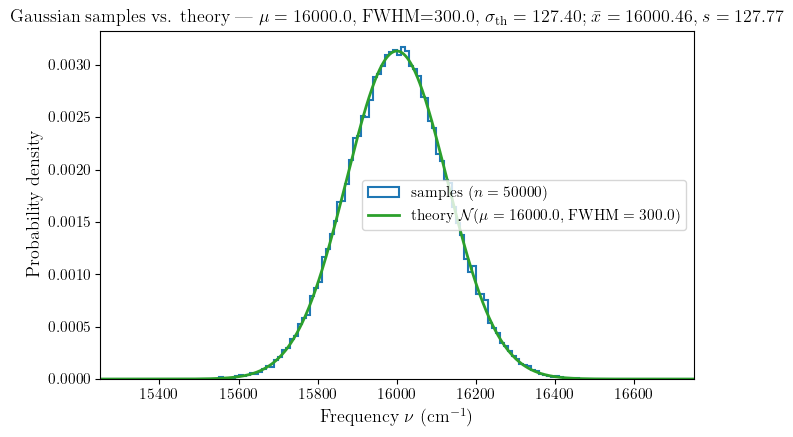

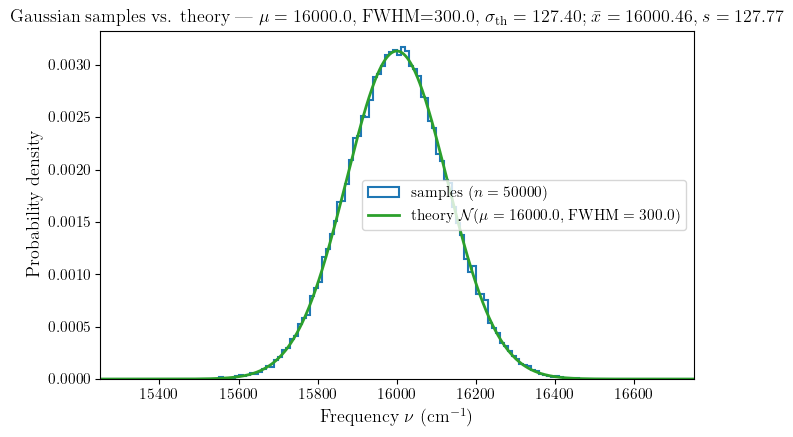

Samples shape (n_samples, n_centers): (20000, 4)
Means per center: [15101.04 15300.2  15498.74 15699.76]
Stds  per center: [128.64 127.47 127.48 127.77]


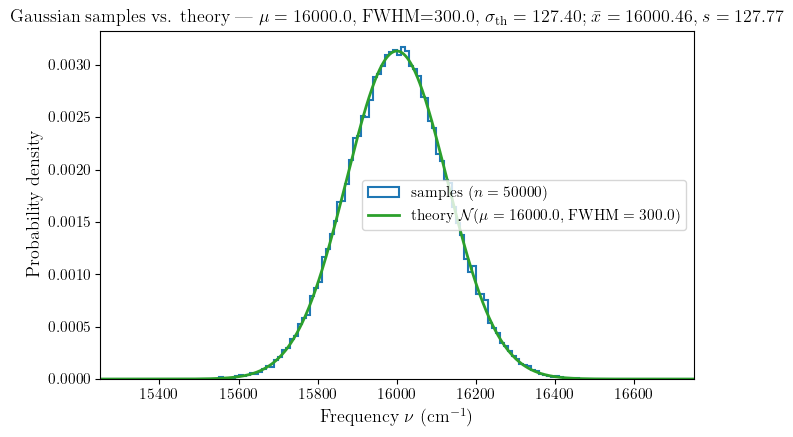

Samples shape (n_samples, n_centers): (20000, 4)
Means per center: [15101.04 15300.2  15498.74 15699.76]
Stds  per center: [128.64 127.47 127.48 127.77]


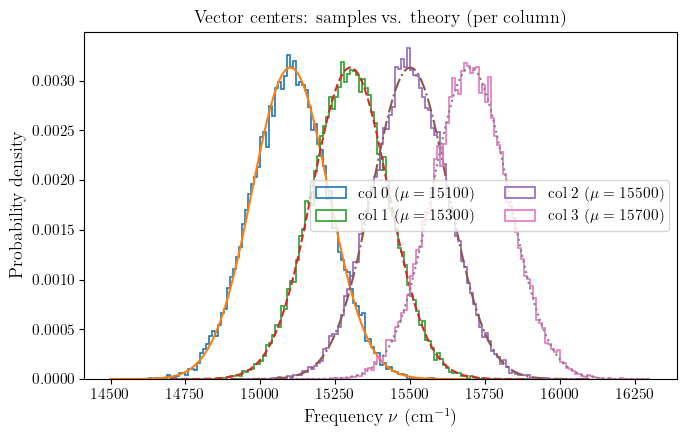

In [3]:
# Run a few visual checks for scalar and vector centers

# Scalar center
mu_scalar   = 16000.0  # cm^-1
fwhm_scalar = 300.0     # cm^-1
_ = plot_gaussian_check(
    mu_scalar,
    fwhm_scalar,
    n_samples=50_000,
    bins=150,
    colors=(COLORS[0], COLORS[2]),
    linestyles=(LINE_STYLES[0],)
 )
plt.tight_layout()
plt.show()

# Vector centers (multiple atoms); check shape and per-column stats
centers = np.array([15_100.0, 15_300.0, 15_500.0, 15_700.0])
fwhm    = 300.0
ns      = 20_000
samples = sample_from_gaussian(ns, fwhm, centers)
print("Samples shape (n_samples, n_centers):", samples.shape)

means = samples.mean(axis=0)
stds  = samples.std(axis=0, ddof=1)
print("Means per center:", np.round(means, 2))
print("Stds  per center:", np.round(stds, 2))

# Overlay histograms for a couple of columns
fig, ax = plt.subplots(figsize=(7, 4.5))
style_cycle = zip(COLORS[::2], COLORS[1::2], LINE_STYLES)
for i, (c_hist, c_line, ls) in enumerate(style_cycle):
    if i >= centers.size:
        break
    center = centers[i]
    x      = np.linspace(center - 2 * fwhm, center + 2 * fwhm, 600)
    ax.hist(
        samples[:, i],
        bins=120,
        range=(center - 2 * fwhm, center + 2 * fwhm),
        density=True,
        histtype="step",
        color=c_hist,
        linewidth=1.2,
        label=rf"col {i} ($\mu={center:.0f}$)"
)
    ax.plot(
        x,
        normalized_gauss(x, fwhm=fwhm, mu=center),
        color=c_line,
        linestyle=ls,
        linewidth=1.5
)
ax.set_xlabel(r"Frequency $\nu$ (cm$^{-1}$)")
ax.set_ylabel(r"Probability density")
ax.set_title(r"Vector centers: samples vs. theory (per column)")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

## Visual Checks for Scalar and Vector Centers

Sample large ensembles from the Gaussian distribution, compare with theory, and verify multi-atom sampling statistics.

In [4]:
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian
import numpy as np

base = np.array([12100.0, 12300.0, 12500.0])
delta = 100.0
ns    = 10_000

S = sample_from_gaussian(ns, delta, base)
print(S.shape)                  # (10000, 3)
print(np.round(S.mean(0), 1))   # close to base
print(np.round(S.std(0), 1))    # ~ delta/(2*sqrt(2*ln2))

(10000, 3)
[12099.8 12299.6 12499.5]
[42.3 42.4 42.8]


## Quick Shape and Moment Regression Test

Confirm that multidimensional sampling preserves target means and widths for a smaller system.

(<Figure size 800x600 with 2 Axes>, <Axes3D: >)

(<Figure size 800x600 with 2 Axes>, <Axes3D: >)

c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


(<Figure size 800x600 with 2 Axes>, <Axes3D: >)

c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\leopo\anaconda3\envs\m_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


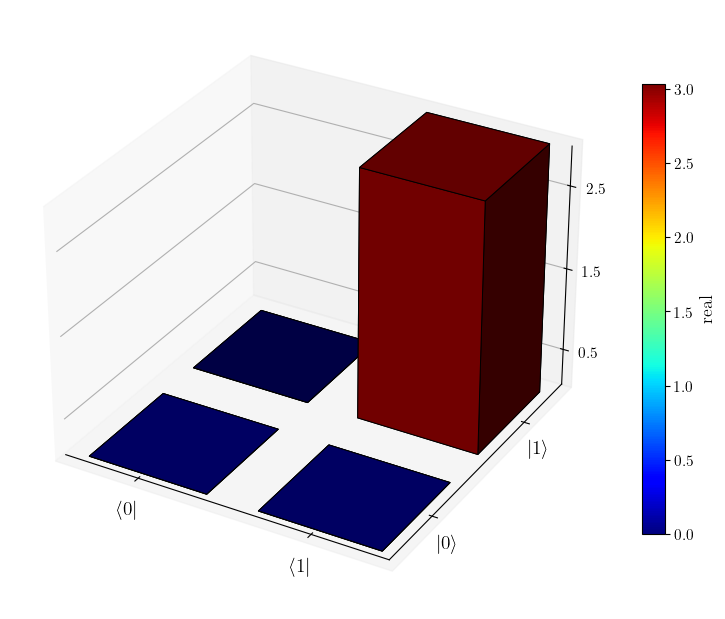

In [5]:
from qutip import matrix_histogram
from qspectro2d.core.atomic_system import AtomicSystem
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian
sys = AtomicSystem(
    n_atoms=1,
    dip_moments=[1.0],
    frequencies_cm=[16000.0],
    delta_inhomogen_cm=300.0,
)
sys.frequencies_cm
n_inhomogen = 10

freqs = sample_from_gaussian(n_inhomogen, sys.delta_inhomogen_cm, sys.frequencies_cm)
for f in freqs:
    sys.update_frequencies_cm(f)
    H = sys.hamiltonian
matrix_histogram(H)

## Hamiltonian Sensitivity Test

Sweep over inhomogeneous frequency samples for a single atom and visualise the resulting Hamiltonians to confirm that updates propagate into the system operators.

## Eigenvalue Diagnostics

Quantify how stochastic detunings modify Hamiltonian spectra by logging eigenvalue gaps and their correlation with sampled frequencies.

In [6]:
# Diagnostic: verify sampled frequencies propagate into Hamiltonian and eigenvalues
import numpy as np
from qspectro2d.core.atomic_system import AtomicSystem
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian, _fwhm_to_sigma
from qspectro2d.utils import convert_cm_to_fs

# Parameters
base_freq_cm      = 16000.0
fwhm_cm           = 300.0
n_inhomogen       = 12  # keep small for speed

# Fresh system instance (avoid history side-effects)
sys_diag = AtomicSystem(
    n_atoms=1,
    dip_moments=[1.0],
    frequencies_cm=[base_freq_cm],
    delta_inhomogen_cm=fwhm_cm,
)

# Draw frequency samples (shape (n_inhomogen,))
samples_cm = sample_from_gaussian(n_inhomogen, fwhm_cm, base_freq_cm)
samples_cm = np.asarray(samples_cm, dtype=float).ravel()

record = []  # will store tuples (freq_cm, eigvals_fs, H_diag_elements_fs)

for i, nu_cm in enumerate(samples_cm):
    sys_diag.update_frequencies_cm([float(nu_cm)])
    H = sys_diag.hamiltonian          # Hamiltonian in (probably) energy units consistent with fs^-1 after conversion
    # Eigenvalues (should reflect updated transition frequency in excited state energy)
    eigvals = np.array(H.eigenenergies())
    # Extract diagonal (for monomer it's already diagonal after building eigenbasis)
    diag_vals = np.diag(H.full())
    record.append((nu_cm, eigvals.copy(), diag_vals.copy()))

# Convert sampled cm^-1 to fs^-1 using helper; for a 2-level system we expect excited-ground gap ~ convert_cm_to_fs(nu_cm)
converted_samples_fs = convert_cm_to_fs(samples_cm)

# Build arrays for analysis
freqs_cm_arr   = np.array([r[0] for r in record])
eig_gap_fs_arr = np.array([r[1][1] - r[1][0] for r in record])  # excited - ground

# Basic statistics
corr = np.corrcoef(converted_samples_fs, eig_gap_fs_arr)[0, 1]

print("Inhomogeneous frequency sampling diagnostics:")
print(f"  n_samples                : {n_inhomogen}")
print(f"  Base freq (cm^-1)        : {base_freq_cm}")
print(f"  FWHM (cm^-1)             : {fwhm_cm}")
print(f"  Sampled freq range (cm^-1): [{freqs_cm_arr.min():.1f}, {freqs_cm_arr.max():.1f}]")
print(f"  Eigen gap range (fs^-1)  : [{eig_gap_fs_arr.min():.5f}, {eig_gap_fs_arr.max():.5f}]")
print(f"  Pearson corr(sample_cm→eig_gap_fs): {corr:.6f}")

# Sanity check: differences between successive updates (should not all be zero)
unique_gaps = np.unique(np.round(eig_gap_fs_arr, 10))
print(f"  Unique eigen gaps count  : {unique_gaps.size}")
if unique_gaps.size == 1:
    print("  ❌ All eigen gaps identical -> frequency update NOT influencing Hamiltonian (investigate caching).")
else:
    print("  ✅ Eigen gaps vary with sampled frequencies.")

# Optional: quick textual table
print("\nSample_cm  eig_gap_fs  ratio(eig_gap / conv_cm_to_fs(sample_cm))")
for nu_cm, gap_fs in zip(freqs_cm_arr[:8], eig_gap_fs_arr[:8]):  # limit rows
    expected_fs = convert_cm_to_fs(nu_cm)
    print(f"{nu_cm:9.2f}  {gap_fs:10.5f}  {gap_fs/expected_fs:6.3f}")

# If desired you can assert correlation ~1.0
if corr < 0.999:
    print("  ⚠️ Correlation < 0.999: scaling or unit mismatch suspected.")

# NOTE:
# For a monomer Hamiltonian often H = diag(0, ω_eg). If additional shifts (e.g., RWA offsets) are applied elsewhere,
# comparison should be done before applying rotating-frame transformations.

Inhomogeneous frequency sampling diagnostics:
  n_samples                : 12
  Base freq (cm^-1)        : 16000.0
  FWHM (cm^-1)             : 300.0
  Sampled freq range (cm^-1): [15768.1, 16216.2]
  Eigen gap range (fs^-1)  : [2.97024, 3.05465]
  Pearson corr(sample_cm→eig_gap_fs): 1.000000
  Unique eigen gaps count  : 12
  ✅ Eigen gaps vary with sampled frequencies.

Sample_cm  eig_gap_fs  ratio(eig_gap / conv_cm_to_fs(sample_cm))
 16130.56     3.03851   1.000
 15937.43     3.00213   1.000
 15982.86     3.01069   1.000
 16211.02     3.05367   1.000
 16185.96     3.04895   1.000
 16187.82     3.04930   1.000
 16216.21     3.05465   1.000
 16076.05     3.02824   1.000


### Tabulated Eigenvalue Deviations

Display a concise table comparing expected vs. observed eigenvalue gaps and their relative mismatch.

## Simulation Object Integration Test

Confirm that the inhomogeneous sampling routine affects a full `SimOQS` instance by stepping through frequency updates and inspecting the resulting Hamiltonians.

In [2]:
from qspectro2d.config import create_base_sim_oqs

test, _ = create_base_sim_oqs()


base_freq_cm      = 16000.0
fwhm_cm           = 300.0
n_inhomogen       = 12  # keep small for speed

# Fresh system instance (avoid history side-effects)
test.system.delta_inhomogen_cm = fwhm_cm
test.simulation_config.n_inhomogen = n_inhomogen
print("the current freqs are", test.system.frequencies_cm,
      "the current delta is", test.system.delta_inhomogen_cm,
      "the current n_inhomogen is", test.simulation_config.n_inhomogen
      )
# Draw frequency samples (shape (n_inhomogen,))
samples_cm = sample_from_gaussian(n_inhomogen, fwhm_cm, base_freq_cm)
samples_cm = np.asarray(samples_cm, dtype=float).ravel()

record = []  # will store tuples (freq_cm, eigvals_fs, H_diag_elements_fs)

for i, nu_cm in enumerate(samples_cm):
    test.system.update_frequencies_cm([float(nu_cm)])
    H = test.system.hamiltonian          # Hamiltonian in (probably) energy units consistent with fs^-1 after conversion
    # Eigenvalues (should reflect updated transition frequency in excited state energy)
    eigvals = np.array(H.eigenenergies())
    # Extract diagonal (for monomer it's already diagonal after building eigenbasis)
    diag_vals = np.diag(H.full())
    record.append((nu_cm, eigvals.copy(), diag_vals.copy()))

# Convert sampled cm^-1 to fs^-1 using helper; for a 2-level system we expect excited-ground gap ~ convert_cm_to_fs(nu_cm)
converted_samples_fs = convert_cm_to_fs(samples_cm)

# Build arrays for analysis
freqs_cm_arr   = np.array([r[0] for r in record])
eig_gap_fs_arr = np.array([r[1][1] - r[1][0] for r in record])  # excited - ground

# Basic statistics
corr = np.corrcoef(converted_samples_fs, eig_gap_fs_arr)[0, 1]

print("Inhomogeneous frequency sampling diagnostics:")
print(f"  n_samples                : {n_inhomogen}")
print(f"  Base freq (cm^-1)        : {base_freq_cm}")
print(f"  FWHM (cm^-1)             : {fwhm_cm}")
print(f"  Sampled freq range (cm^-1): [{freqs_cm_arr.min():.1f}, {freqs_cm_arr.max():.1f}]")
print(f"  Eigen gap range (fs^-1)  : [{eig_gap_fs_arr.min():.5f}, {eig_gap_fs_arr.max():.5f}]")
print(f"  Pearson corr(sample_cm→eig_gap_fs): {corr:.6f}")

# Sanity check: differences between successive updates (should not all be zero)
unique_gaps = np.unique(np.round(eig_gap_fs_arr, 10))
print(f"  Unique eigen gaps count  : {unique_gaps.size}")
if unique_gaps.size == 1:
    print("  ❌ All eigen gaps identical -> frequency update NOT influencing Hamiltonian (investigate caching).")
else:
    print("  ✅ Eigen gaps vary with sampled frequencies.")

# Optional: quick textual table
print("\nSample_cm  eig_gap_fs  ratio(eig_gap / conv_cm_to_fs(sample_cm))")
for nu_cm, gap_fs in zip(freqs_cm_arr[:8], eig_gap_fs_arr[:8]):  # limit rows
    expected_fs = convert_cm_to_fs(nu_cm)
    print(f"{nu_cm:9.2f}  {gap_fs:10.5f}  {gap_fs/expected_fs:6.3f}")

# If desired you can assert correlation ~1.0
if corr < 0.999:
    print("  ⚠️ Correlation < 0.999: scaling or unit mismatch suspected.")

# NOTE:
# For a monomer Hamiltonian often H = diag(0, ω_eg). If additional shifts (e.g., RWA offsets) are applied elsewhere,
# comparison should be done before applying rotating-frame transformations.

🔧 Configured to use max_workers=12 for parallel tasks.


🔧 Configured to use max_workers=12 for parallel tasks.


🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
=== SOLVER DIAGNOSTICS ===
Solver: redfield
Time range: t0=-30.000, t_max=40.000, dt=1.000000
Number of time points: 71
RWA enabled: True
=== SYSTEM DIAGNOSTICS ===
Initial state type, shape, is hermitian, trace: <class 'qutip.core.qobj.Qobj'>, (2, 2), True, 1.000000
Initial eigenvalues range: [0.000000, 1.000000]
Initial min eigenvalue: 0.0000000000
Total Hamiltonian dims: [[2], [2]]
Total Hamiltonian type: <class 'qutip.core.cy.qobjevo.QobjEvo'>
Number of decay channels: 2
Applying RWA phase factors: n_atoms=1, omega_laser=3.0139183281479043 [fs^-1]
=== STATE-BY-STATE ANALYSIS ===
✅ Checks passed. DM remains Hermitian and positive.
Final state trace: 1.000000
Final state min eigenvalue: 0.0000355999
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)
the current freqs are [16000.0] the current delta is 300.0 the cur

🔧 Configured to use max_workers=12 for parallel tasks.


🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
=== SOLVER DIAGNOSTICS ===
Solver: redfield
Time range: t0=-30.000, t_max=40.000, dt=1.000000
Number of time points: 71
RWA enabled: True
=== SYSTEM DIAGNOSTICS ===
Initial state type, shape, is hermitian, trace: <class 'qutip.core.qobj.Qobj'>, (2, 2), True, 1.000000
Initial eigenvalues range: [0.000000, 1.000000]
Initial min eigenvalue: 0.0000000000
Total Hamiltonian dims: [[2], [2]]
Total Hamiltonian type: <class 'qutip.core.cy.qobjevo.QobjEvo'>
Number of decay channels: 2
Applying RWA phase factors: n_atoms=1, omega_laser=3.0139183281479043 [fs^-1]
=== STATE-BY-STATE ANALYSIS ===
✅ Checks passed. DM remains Hermitian and positive.
Final state trace: 1.000000
Final state min eigenvalue: 0.0000355999
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)
the current freqs are [16000.0] the current delta is 300.0 the cur

NameError: name 'sample_from_gaussian' is not defined

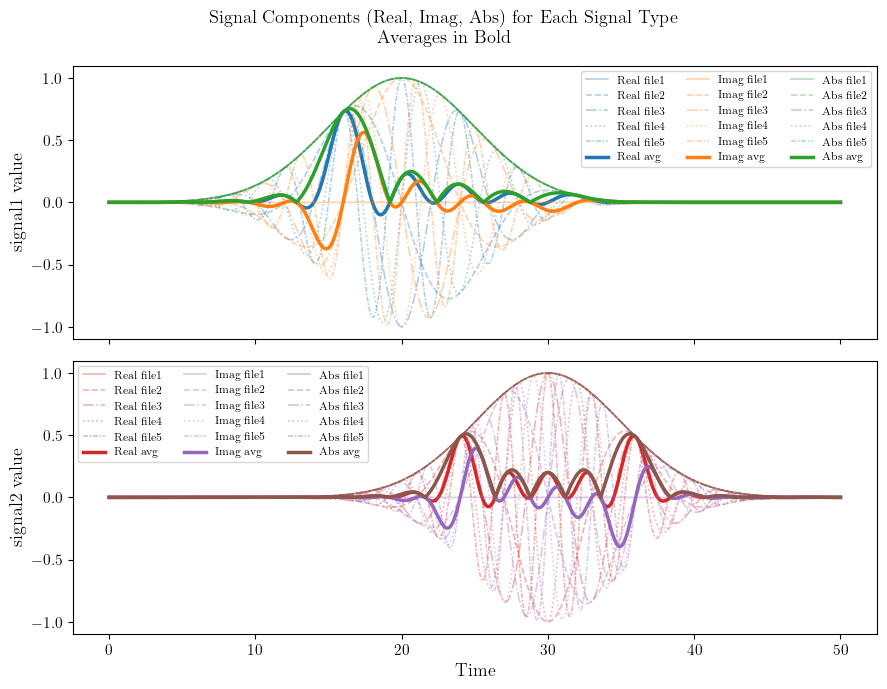

In [ ]:
from typing import List
t = np.linspace(0, 50, 10000)  # time indices

# Dummy stacks: simulate 2 complex signal types, 2 files each, using Gaussian pulses with offsets and phase
dummy_stacks = {
    'signal1': [],
    'signal2': []
}

r = 5
for i in range(r):
    # Add a varying phase for each file to make signals complex
    phase1 = np.pi / 8 * i
    phase2 = np.pi / 6 * i

    # Gaussian for signal1 centered at t=20, with complex phase
    sig1 = np.exp(-((t - 20)**2) / (2 * 5**2)) * np.exp(1j * phase1 * t)
    # Gaussian for signal2 centered at t=30 (offset from signal1), with complex phase
    sig2 = np.exp(-((t - 30)**2) / (2 * 5**2)) * np.exp(1j * phase2 * t)

    dummy_stacks['signal1'].append(sig1)
    dummy_stacks['signal2'].append(sig2)

dummy_metadata = {
    'signal_types': ['signal1', 'signal2'],
    't_coh_value': 0.5,
    'inhom_group_id': 'test_group',
}

signal_types = dummy_metadata["signal_types"]

# Average
averaged: List[np.ndarray] = []
for k in signal_types:
    data = np.stack(dummy_stacks[k], axis=0)  # (n_files, t_det)
    averaged.append(np.mean(data, axis=0))
t = np.linspace(0, 50, 10000)  # time indices

# Plot each signal component (real, imag, abs) for both signals on separate subplots
fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

signal_labels = ['signal1', 'signal2']
comp_labels = ['Real', 'Imag', 'Abs']
comp_funcs = [np.real, np.imag, np.abs]
alpha = 0.35

for idx, sig in enumerate(signal_labels):
    for i, comp in enumerate(comp_funcs):
        for j, arr in enumerate(dummy_stacks[sig]):
            axes[idx].plot(
                t, comp(arr),
                label=f'{comp_labels[i]} file{j+1}',
                color=COLORS[i + 3 * idx],
                linestyle=LINE_STYLES[j],
                alpha=alpha,
                linewidth=1.2
            )
        # Plot average in bold
        axes[idx].plot(
            t, comp(averaged[idx]),
            label=f'{comp_labels[i]} avg',
            color=COLORS[i + 3 * idx],
            linestyle='solid',
            linewidth=2.5
        )
    axes[idx].set_ylabel(f'{sig} value')
    axes[idx].legend(ncol=3, fontsize=8)

axes[-1].set_xlabel('Time')
plt.suptitle('Signal Components (Real, Imag, Abs) for Each Signal Type\nAverages in Bold')
plt.tight_layout()
plt.show()

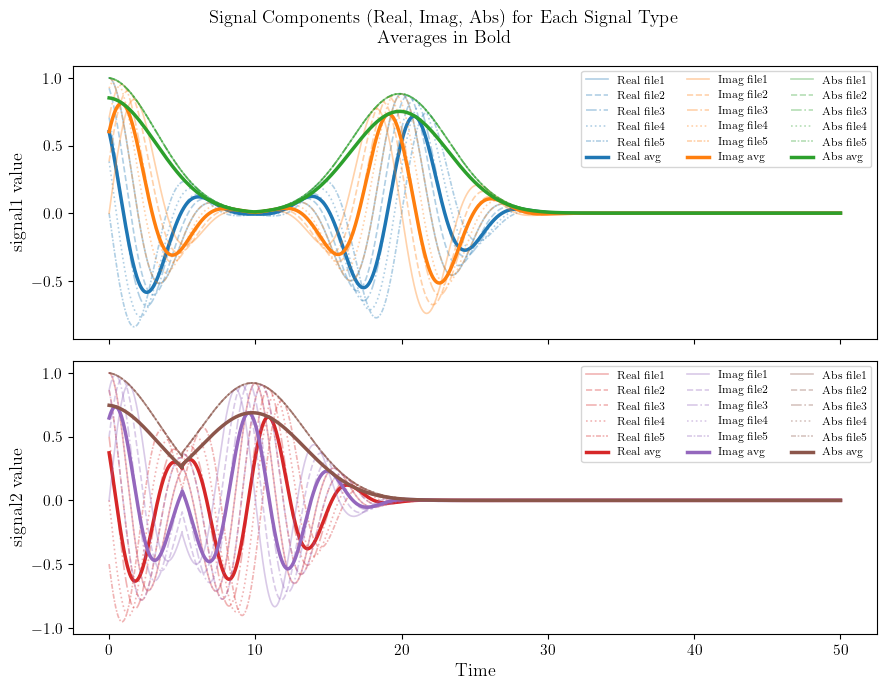

In [ ]:
# --- echo model helpers ---
def hahn_echo_signal(t, tau, w0, sigma, T2=np.inf, phi=0.0):
    """
    Ensemble-averaged Hahn-echo signal with Gaussian inhomogeneous width 'sigma'.
    t    : time array
    tau  : delay of the pi-pulse (echo at t=2*tau)
    w0   : carrier angular frequency (rad/s, use arbitrary units here)
    sigma: std of inhomogeneous detuning distribution (rad/s)
    T2   : homogeneous dephasing time (same units as t). Use np.inf to ignore.
    phi  : additional phase offset
    """
    t = np.asarray(t)
    S = np.zeros_like(t, dtype=complex)
    pre = t < tau
    post = ~pre

    # homogeneous decay factor
    hom_pre = np.exp(-t[pre] / T2) if np.isfinite(T2) else 1.0
    hom_post = np.exp(-(t[post] - tau) / T2) if np.isfinite(T2) else 1.0

    # pre-pi pulse FID (Gaussian dephasing from inhomogeneity)
    S[pre] = hom_pre * np.exp(-0.5 * (sigma * t[pre])**2) * np.exp(1j * (w0 * t[pre] + phi))

    # post-pi pulse rephasing (mirror time coordinate: te = 2*tau - t)
    te = 2 * tau - t[post]
    S[post] = hom_post * np.exp(-0.5 * (sigma * te)**2) * np.exp(1j * (w0 * te + phi))

    return S

# --- replace your Gaussian dummy signals with echo signals ---
dummy_stacks = {'signal1': [], 'signal2': []}

r = 5
tau1, tau2 = 10.0, 15.0   # pi-pulse times → echoes at 20 and 30, respectively
w0_1, w0_2 = 0.8, 1.1     # arbitrary carrier angular freqs
sigma1, sigma2 = 0.3, 0.28  # inhomogeneous widths (broader → faster FID/echo narrowing)
T2_1, T2_2 = 80.0, 60.0   # homogeneous T2 (set np.inf to ignore)
for i in range(r):
    # small file-to-file phase changes (keeps your "complex files" idea)
    phase1 = np.pi / 8 * i
    phase2 = np.pi / 6 * i

    sig1 = hahn_echo_signal(t, tau=tau1, w0=w0_1, sigma=sigma1, T2=T2_1, phi=phase1)
    sig2 = hahn_echo_signal(t, tau=tau2, w0=w0_2, sigma=sigma2, T2=T2_2, phi=phase2)

    dummy_stacks['signal1'].append(sig1)
    dummy_stacks['signal2'].append(sig2)


dummy_metadata = {
    'signal_types': ['signal1', 'signal2'],
    't_coh_value': 0.5,
    'inhom_group_id': 'test_group',
}

signal_types = dummy_metadata["signal_types"]

# Average
averaged: List[np.ndarray] = []
for k in signal_types:
    data = np.stack(dummy_stacks[k], axis=0)  # (n_files, t_det)
    averaged.append(np.mean(data, axis=0))
t = np.linspace(0, 50, 10000)  # time indices

# Plot each signal component (real, imag, abs) for both signals on separate subplots
fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)

signal_labels = ['signal1', 'signal2']
comp_labels = ['Real', 'Imag', 'Abs']
comp_funcs = [np.real, np.imag, np.abs]
alpha = 0.35

for idx, sig in enumerate(signal_labels):
    for i, comp in enumerate(comp_funcs):
        for j, arr in enumerate(dummy_stacks[sig]):
            axes[idx].plot(
                t, comp(arr),
                label=f'{comp_labels[i]} file{j+1}',
                color=COLORS[i + 3 * idx],
                linestyle=LINE_STYLES[j],
                alpha=alpha,
                linewidth=1.2
            )
        # Plot average in bold
        axes[idx].plot(
            t, comp(averaged[idx]),
            label=f'{comp_labels[i]} avg',
            color=COLORS[i + 3 * idx],
            linestyle='solid',
            linewidth=2.5
        )
    axes[idx].set_ylabel(f'{sig} value')
    axes[idx].legend(ncol=3, fontsize=8)

axes[-1].set_xlabel('Time')
plt.suptitle('Signal Components (Real, Imag, Abs) for Each Signal Type\nAverages in Bold')
plt.tight_layout()
plt.show()